In [97]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [98]:
import tensorflow_datasets as tfds

# Download the plain text default config
imdb_plaintext, info_plaintext = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Download the subword encoded pretokenized dataset
imdb_subwords, info_subwords = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [99]:
# Splitting The Datasets
train_plaintext, test_plaintext = imdb_plaintext['train'], imdb_plaintext['test']
train_subwords, test_subwords = imdb_subwords['train'], imdb_subwords['test']

In [100]:
tokenizer_subwords = info_subwords.features['text'].encoder
VOCAB_SIZE_SUBWORDS = tokenizer_subwords.vocab_size

# Preparing plaintext

In [101]:
# Extracting Sentences and Labels
train_sentences_plaintext = []
train_label_plaintext = []
test_sentences_plaintext = []
test_label_plaintext = []

for i in tqdm(train_plaintext):
    x, y = i
    train_sentences_plaintext.append(x.numpy().decode("utf8"))
    train_label_plaintext.append(y.numpy())
    
for i in tqdm(test_plaintext):
    x, y = i
    test_sentences_plaintext.append(x.numpy().decode("utf8"))
    test_label_plaintext.append(y.numpy())

100%|██████████| 25000/25000 [00:10<00:00, 2439.67it/s]


In [102]:
# Initializing and Fitting Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_plaintext = Tokenizer(oov_token="<OOV>")
tokenizer_plaintext.fit_on_texts(train_sentences_plaintext)

VOCAB_SIZE_PLAINTEXT = len(tokenizer_plaintext.word_counts)

In [103]:
# Creating Sequence from tokenizer
train_sequences_plaintext = tokenizer_plaintext.texts_to_sequences(train_sentences_plaintext)
test_sequences_plaintext = tokenizer_plaintext.texts_to_sequences(test_sentences_plaintext)

MAXLEN_PLAINTEXT = max(len(i) for i in train_sequences_plaintext)

In [104]:
# Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_padded_plaintext = pad_sequences(train_sequences_plaintext, maxlen=MAXLEN_PLAINTEXT)
test_padded_plaintext = pad_sequences(test_sequences_plaintext, maxlen=MAXLEN_PLAINTEXT)

In [105]:
# Converting to Tensorflow Dataset
train_plaintext = tf.data.Dataset.from_tensor_slices((train_padded_plaintext, train_label_plaintext))
test_plaintext = tf.data.Dataset.from_tensor_slices((test_padded_plaintext, test_label_plaintext))

 # Creating Model

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Bidirectional, LSTM, GRU, Conv1D

In [107]:
VOCAB_SIZE_PLAINTEXT, VOCAB_SIZE_SUBWORDS

(88582, 8185)

In [108]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

# Shuffle the training data
train_plaintext = train_plaintext.shuffle(BUFFER_SIZE)
test_plaintext = test_plaintext.shuffle(BUFFER_SIZE)
train_subwords = train_subwords.shuffle(BUFFER_SIZE)
test_subwords = test_subwords.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_plaintext = train_plaintext.padded_batch(BATCH_SIZE)
test_plaintext = test_plaintext.padded_batch(BATCH_SIZE)
train_subwords = train_subwords.padded_batch(BATCH_SIZE)
test_subwords = test_subwords.padded_batch(BATCH_SIZE)

In [109]:
historys = {}

In [110]:
def plot(history):
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.show()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.show()

In [111]:
def apply_model(name, model, train, test, epochs):
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()

    with tf.device('/GPU:0'):
        history = model.fit(train, epochs=epochs, validation_data=test)
        history = history.history

        plot(history)
        historys[name] = history

## Embedding

In [112]:
EMB_DIM = 16

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 16)          1417312   
                                                                 
 global_average_pooling1d_10  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,417,329
Trainable params: 1,417,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
782/782 [==============================] - 5s 6ms/step - loss: 0.6901 - accuracy: 0.5654 - val_loss: 0.6849 - val_accuracy: 0.7125
Epoch 2/20
782/782 [==============================] - 5s 6ms/step - loss: 0.6703 - accuracy: 0.6962

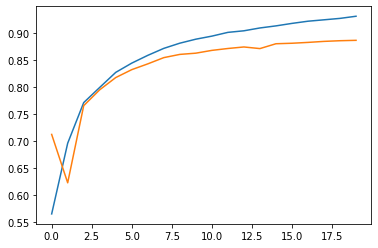

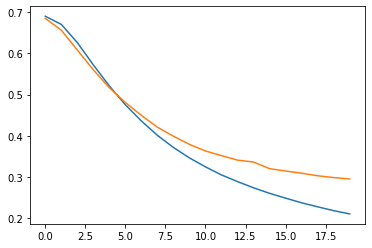

In [113]:
# Plaintext With Embedding
model = Sequential([
    Embedding(VOCAB_SIZE_PLAINTEXT, EMB_DIM),
	GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid'),
])
apply_model(
    name = "Plaintext With Embedding",
    model = model,
    train = train_plaintext,
    test = test_plaintext,
    epochs = 20,
)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 16)          130960    
                                                                 
 global_average_pooling1d_11  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
782/782 [==============================] - 7s 8ms/step - loss: 0.6827 - accuracy: 0.6050 - val_loss: 0.6636 - val_accuracy: 0.6641
Epoch 2/20
782/782 [==============================] - 5s 6ms/step - loss: 0.6226 - accuracy: 0.7509 - v

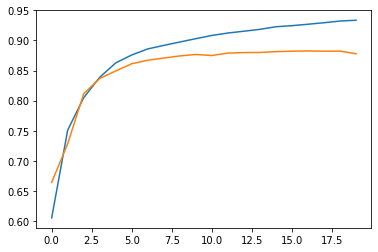

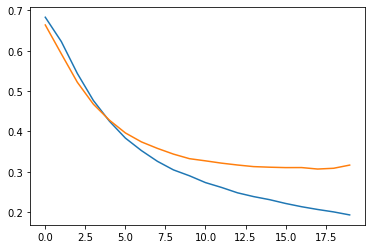

In [114]:
# Subwords With Embedding
model = Sequential([
    Embedding(VOCAB_SIZE_SUBWORDS, EMB_DIM),
	GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid'),
])
apply_model(
    name = 'Subwords With Embedding',
    model = model,
    train = train_subwords,
    test = test_subwords,
    epochs = 20,
)

## Single LSTM

In [115]:
EMB_DIM = 16
LSTM_DIM = 30

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 16)          1417312   
                                                                 
 bidirectional_11 (Bidirecti  (None, 60)               11280     
 onal)                                                           
                                                                 
 dense_28 (Dense)            (None, 1)                 61        
                                                                 
Total params: 1,428,653
Trainable params: 1,428,653
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
782/782 [==============================] - 145s 183ms/step - loss: 0.4486 - accuracy: 0.7875 - val_loss: 0.3505 - val_accuracy: 0.8492
Epoch 2/2
782/782 [==============================] - 144s 184ms/step - loss: 0.2092 - accuracy: 

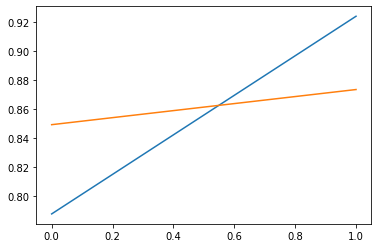

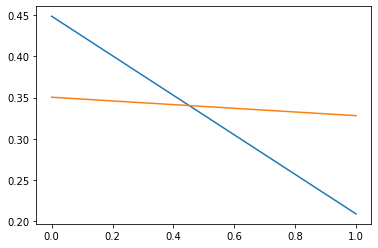

In [116]:
# Plaintext With Single LSTM
model = Sequential([
    Embedding(VOCAB_SIZE_PLAINTEXT, EMB_DIM),
    Bidirectional(LSTM(LSTM_DIM)),
    Dense(1, activation='sigmoid'),
])
apply_model(
    name = "Plaintext With Single LSTM",
    model = model,
    train = train_plaintext,
    test = test_plaintext,
    epochs = 2,
)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 16)          130960    
                                                                 
 bidirectional_12 (Bidirecti  (None, 60)               11280     
 onal)                                                           
                                                                 
 dense_29 (Dense)            (None, 1)                 61        
                                                                 
Total params: 142,301
Trainable params: 142,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
782/782 [==============================] - 77s 95ms/step - loss: 0.5616 - accuracy: 0.7022 - val_loss: 0.4864 - val_accuracy: 0.7752
Epoch 2/3
782/782 [==============================] - 73s 93ms/step - loss: 0.3641 - accuracy: 0.8513 -

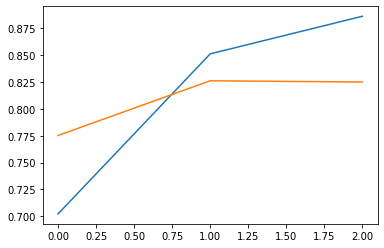

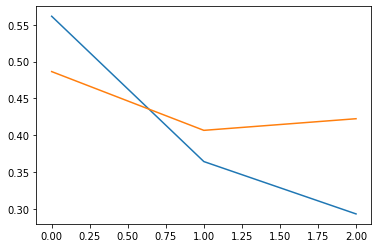

In [117]:
# Subwords With Single LSTM
model = Sequential([
    Embedding(VOCAB_SIZE_SUBWORDS, EMB_DIM),
    Bidirectional(LSTM(LSTM_DIM)),
    Dense(1, activation='sigmoid'),
])
apply_model(
    name = "Subwords With Single LSTM",
    model = model,
    train = train_subwords,
    test = test_subwords,
    epochs = 3,
)

## Multiple LSTM

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, None, 16)          1417312   
                                                                 
 bidirectional_13 (Bidirecti  (None, None, 60)         11280     
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 60)               21840     
 onal)                                                           
                                                                 
 dense_30 (Dense)            (None, 1)                 61        
                                                                 
Total params: 1,450,493
Trainable params: 1,450,493
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
782/782 [========================

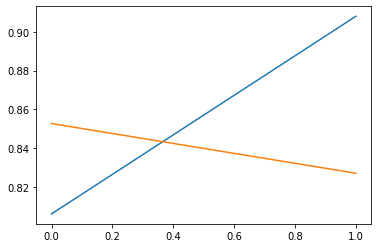

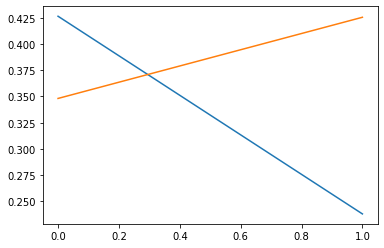

In [118]:
# Plaintext With Multiple LSTM
model = Sequential([
    Embedding(VOCAB_SIZE_PLAINTEXT, EMB_DIM),
    Bidirectional(LSTM(LSTM_DIM, return_sequences=True)),
    Bidirectional(LSTM(LSTM_DIM)),
    Dense(1, activation='sigmoid'),
])
apply_model(
    name = "Plaintext With Multiple LSTM",
    model = model,
    train = train_plaintext,
    test = test_plaintext,
    epochs = 2,
)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 16)          130960    
                                                                 
 bidirectional_15 (Bidirecti  (None, None, 60)         11280     
 onal)                                                           
                                                                 
 bidirectional_16 (Bidirecti  (None, 60)               21840     
 onal)                                                           
                                                                 
 dense_31 (Dense)            (None, 1)                 61        
                                                                 
Total params: 164,141
Trainable params: 164,141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
782/782 [============================

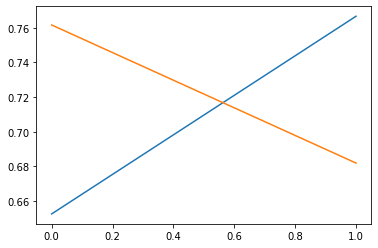

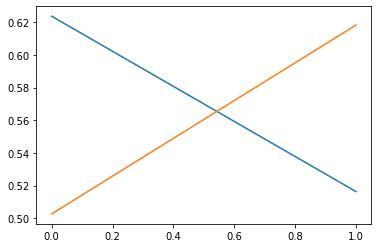

In [119]:
# Subwords With Multiple LSTM
model = Sequential([
    Embedding(VOCAB_SIZE_SUBWORDS, EMB_DIM),
    Bidirectional(LSTM(LSTM_DIM, return_sequences=True)),
    Bidirectional(LSTM(LSTM_DIM)),
    Dense(1, activation='sigmoid'),
])
apply_model(
    name = "Subwords With Single LSTM",
    model = model,
    train = train_subwords,
    test = test_subwords,
    epochs = 2,
)

# GRU

In [120]:
EMB_DIM = 16
GRU_DIM = 30

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 16)          1417312   
                                                                 
 bidirectional_17 (Bidirecti  (None, 60)               8640      
 onal)                                                           
                                                                 
 dense_32 (Dense)            (None, 1)                 61        
                                                                 
Total params: 1,426,013
Trainable params: 1,426,013
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
782/782 [==============================] - 140s 176ms/step - loss: 0.4353 - accuracy: 0.7832 - val_loss: 0.3219 - val_accuracy: 0.8659
Epoch 2/2
782/782 [==============================] - 135s 173ms/step - loss: 0.2124 - accuracy: 

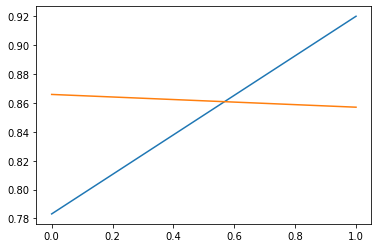

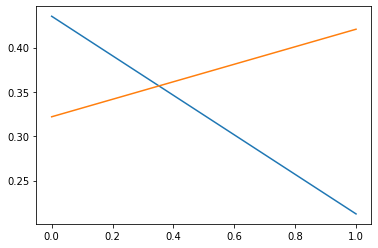

In [121]:
# Plaintext with GRU
model = Sequential([
    Embedding(VOCAB_SIZE_PLAINTEXT, EMB_DIM),
    Bidirectional(GRU(GRU_DIM)),
    Dense(1, activation='sigmoid'),
])
apply_model(
    name = "Plaintext With GRU",
    model = model,
    train = train_plaintext,
    test = test_plaintext,
    epochs = 2,
)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, None, 16)          130960    
                                                                 
 bidirectional_18 (Bidirecti  (None, 60)               8640      
 onal)                                                           
                                                                 
 dense_33 (Dense)            (None, 1)                 61        
                                                                 
Total params: 139,661
Trainable params: 139,661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
782/782 [==============================] - 73s 88ms/step - loss: 0.6719 - accuracy: 0.5739 - val_loss: 0.6828 - val_accuracy: 0.5909
Epoch 2/2
782/782 [==============================] - 68s 87ms/step - loss: 0.6164 - accuracy: 0.6752 -

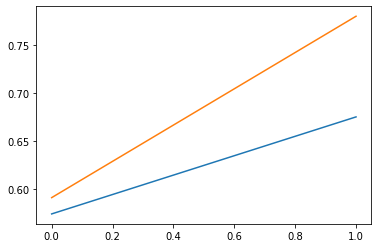

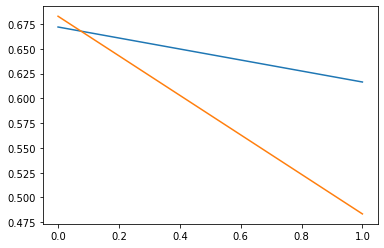

In [122]:
# Subwords with GRU
model = Sequential([
    Embedding(VOCAB_SIZE_SUBWORDS, EMB_DIM),
    Bidirectional(GRU(GRU_DIM)),
    Dense(1, activation='sigmoid'),
])
apply_model(
    name = "Subwords With GRU",
    model = model,
    train = train_subwords,
    test = test_subwords,
    epochs = 2,
)

# Conv1D

In [123]:
EMB_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, None, 16)          1417312   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         10368     
                                                                 
 global_average_pooling1d_12  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,427,809
Trainable params: 1,427,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
782/782 [==============================] - 11s 13ms/step - loss: 0.5194 - accuracy: 0.7447 - val_lo

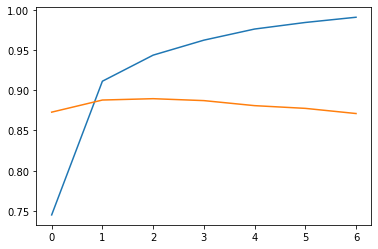

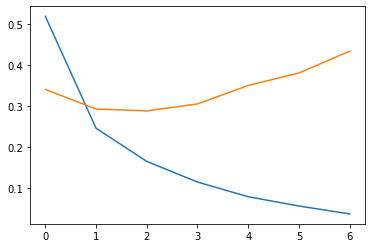

In [124]:
# Plaintext with Conv1D
model = Sequential([
    Embedding(VOCAB_SIZE_PLAINTEXT, EMB_DIM),
    Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])
apply_model(
    name = "Plaintext With Conv1D",
    model = model,
    train = train_plaintext,
    test = test_plaintext,
    epochs = 7,
)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 16)          130960    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         10368     
                                                                 
 global_average_pooling1d_13  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
Total params: 141,457
Trainable params: 141,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
782/782 [==============================] - 9s 11ms/step - loss: 0.4902 - accuracy: 0.7673 - val_loss: 0

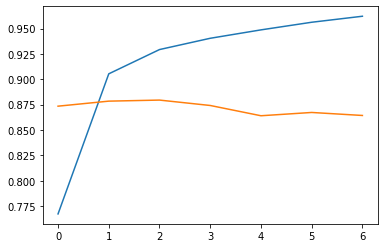

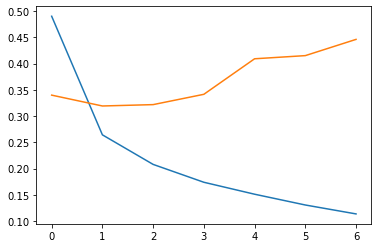

In [125]:
# Subwords with Conv1D
model = Sequential([
    Embedding(VOCAB_SIZE_SUBWORDS, EMB_DIM),
    Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])
apply_model(
    name = "Subwords With Conv1D",
    model = model,
    train = train_subwords,
    test = test_subwords,
    epochs = 7,
)

# Plotting

Plaintext With Embedding 0.887


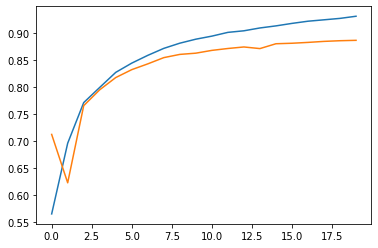

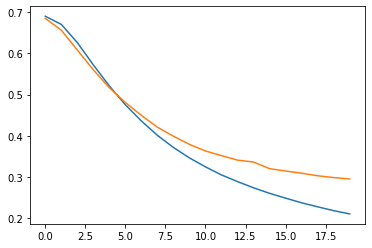

Subwords With Embedding 0.883


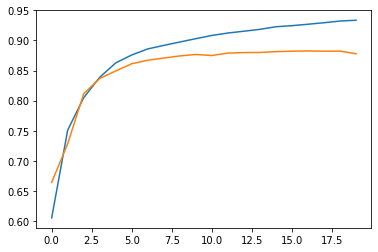

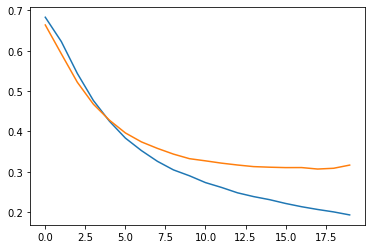

Plaintext With Single LSTM 0.874


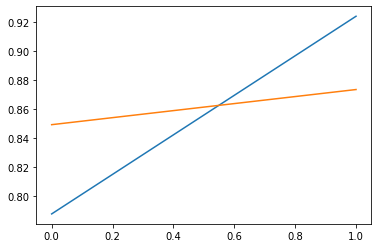

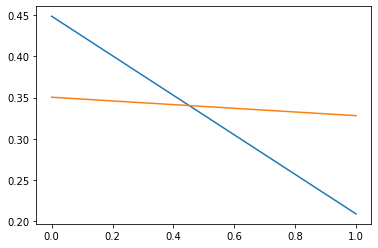

Subwords With Single LSTM 0.762


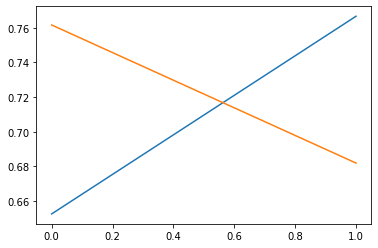

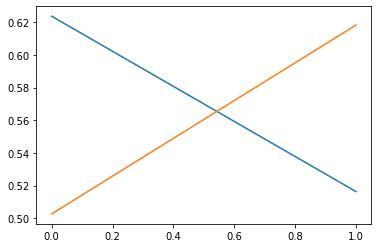

Plaintext With Multiple LSTM 0.853


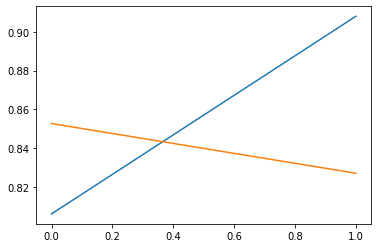

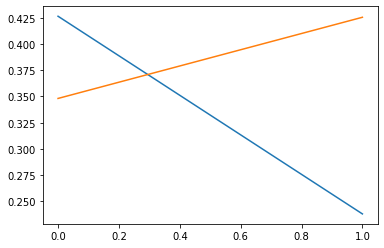

Plaintext With GRU 0.866


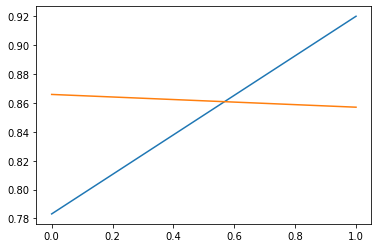

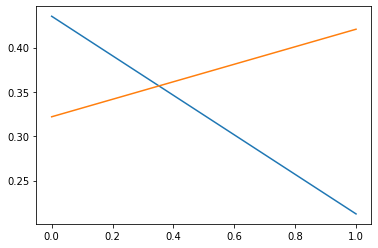

Subwords With GRU 0.78


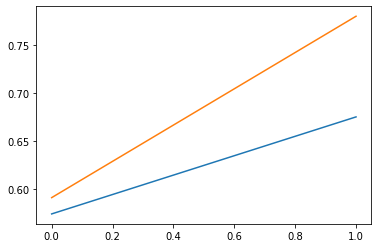

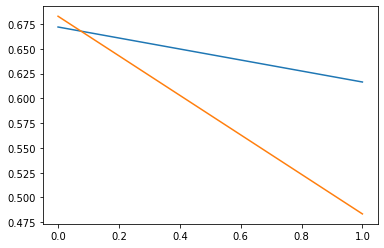

Plaintext With Conv1D 0.89


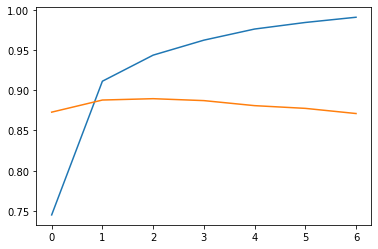

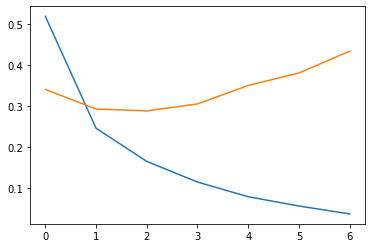

Subwords With Conv1D 0.879


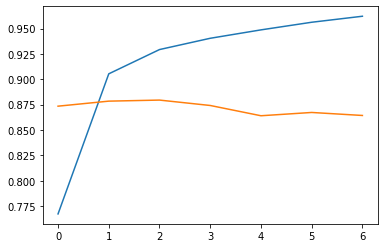

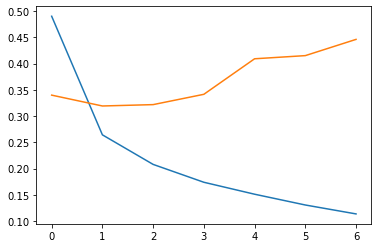

In [128]:
for key, val in historys.items():
    print(key, round(max(val['val_accuracy']), 3))
    plot(val)